In [23]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

!kaggle competitions download -c histopathologic-cancer-detection

import zipfile
import os

zip_file_path = 'histopathologic-cancer-detection.zip'

extract_to_path = 'histopathologic-cancer-detection'

os.makedirs(extract_to_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
histopathologic-cancer-detection.zip: Skipping, found more recently modified local copy (use --force to force download)



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000


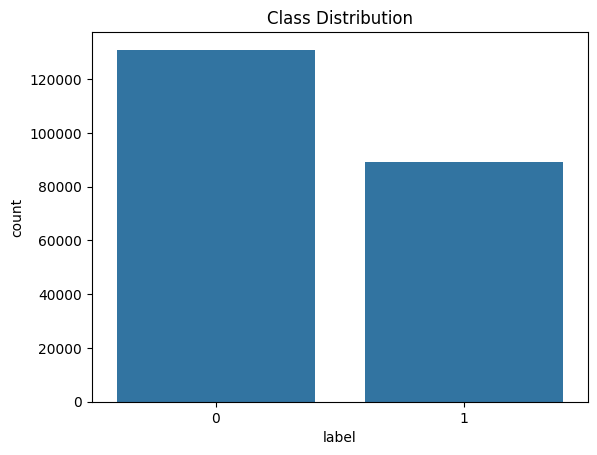

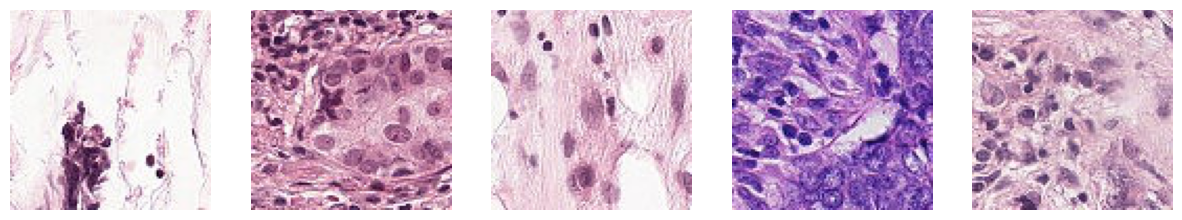

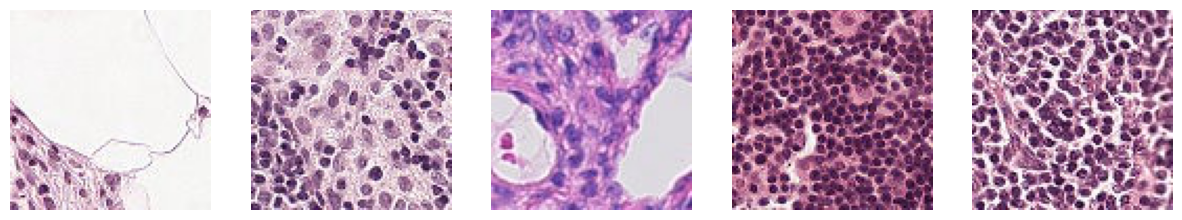

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io

train_labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')

print(train_labels.describe())

sns.countplot(x='label', data=train_labels)
plt.title('Class Distribution')
plt.show()


In [25]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'histopathologic-cancer-detection/train'

train_labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')

train_labels['label'] = train_labels['label'].astype(str)

train_labels['id'] = train_labels['id'].apply(lambda x: x if x.endswith('.tif') else f"{x}.tif")

print(train_labels['id'].head())

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='id',
    y_col='label',
    subset='training',
    batch_size=32,
    shuffle=True,
    class_mode='binary',
    target_size=(96, 96)
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='id',
    y_col='label',
    subset='validation',
    batch_size=32,
    shuffle=True,
    class_mode='binary',
    target_size=(96, 96)
)


Directory histopathologic-cancer-detection/train exists.
Sample files in histopathologic-cancer-detection/train: ['f0c2a0b8ef3024f407fa97d852d49be0215cafe0.tif', '99ef485f205645918613cd04281098daa7c17819.tif', 'e2612e173abd0e8bb54a3c3db3f264b63d80bffb.tif', '6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0.tif', '9c043ab2adadfeb758c71d21432fccd3e43565c0.tif', '9cc775713dd09351172a350871a547346af08027.tif', '1996c210f020134e986823ca7d4df0a70a799c34.tif', '270d16e6b9d88f09f3cc2e538f23091b186a33e5.tif', '731fe361f4af33b5e4f11d74b2bc7508171904e6.tif', 'c7cf86c53ef00698e1e46f430e8527b534bd0368.tif']

Sample filenames in dataframe after appending '.tif':
0    f38a6374c348f90b587e046aac6079959adf3835.tif
1    c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2    755db6279dae599ebb4d39a9123cce439965282d.tif
3    bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4    068aba587a4950175d04c680d38943fd488d6a9d.tif
Name: id, dtype: object
Found 176020 validated image filenames belonging to 2 classes.
Found 44005 va

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,370,561 (12.86 MB)

 Trainable params: 3,370,561 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()

plt.show()


Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  61/5501 ━━━━━━━━━━━━━━━━━━━━ 6:47 75ms/step - accuracy: 0.5948 - loss: 0.7443

KeyboardInterrupt: 

In [27]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(validation_generator)
print(f'{val_loss}')
print(f'{val_acc}')

from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Predictions
y_true = validation_generator.classes
y_pred = model.predict(validation_generator).ravel()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred > 0.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


   3/1376 ━━━━━━━━━━━━━━━━━━━━ 1:11 52ms/step - accuracy: 0.5590 - loss: 0.6917 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 465/1376 ━━━━━━━━━━━━━━━━━━━━ 50s 55ms/step - accuracy: 0.4002 - loss: 0.6980

KeyboardInterrupt: 

In [28]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model.keras')

test_datagen = ImageDataGenerator(rescale=1./255)

test_dir = 'histopathologic-cancer-detection/test'

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

predictions = best_model.predict(test_generator, steps=len(test_generator))

submission = pd.DataFrame({
    'id': [fname.split('/')[-1].split('.')[0] for fname in test_generator.filenames],
    'label': predictions.ravel()
})

submission['label'] = (submission['label'] > 0.5).astype(int)

submission.to_csv('submission.csv', index=False)


Found 0 images belonging to 0 classes.


ValueError: Must provide at least one structure